<a href="https://colab.research.google.com/github/RenataTNT/Algorithms-of-Data-Analysis-/blob/master/RIrnazarova_Lesson_6(edited).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 6. Градиентный бустинг

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [0]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [0]:
from sklearn.datasets import load_diabetes

In [0]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
len(y_train)

331

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [0]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [0]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [0]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [0]:
import random

In [0]:
random.seed(42)

In [0]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, subset_size=0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    fit_size=int(subset_size*len(y_train))


    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        #перемешиваем индексы и берем их случайную подвыборку размером fit_size
        a=np.arange(len(y_train))

        np.random.shuffle(a)
   
        index_array=np.random.choice(a, fit_size, replace=False)

        X_train_new=X_train[index_array]
        y_train_new=y_train[index_array]
        #print(index_array,'index_array')

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_new, y_train_new)
            
            train_errors.append(mean_squared_error(y_train_new, gb_predict(X_train_new, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_new, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_new, bias(y_train_new, target))
            
            train_errors.append(mean_squared_error(y_train_new, gb_predict(X_train_new, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [0]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [0]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [24]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1383.2920223960564
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3801.1262116566418


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [0]:
import matplotlib.pyplot as plt

In [0]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

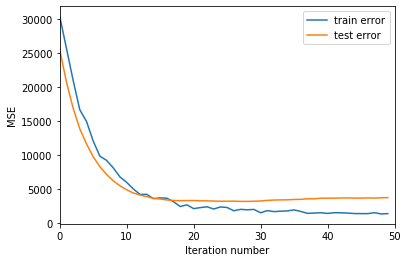

In [27]:
get_error_plot(n_trees, train_errors, test_errors)

Видно, что при большом числе деревьев наступает небольшое переобучение

In [0]:
trees2, train_errors2, test_errors2 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, subset_size=1)

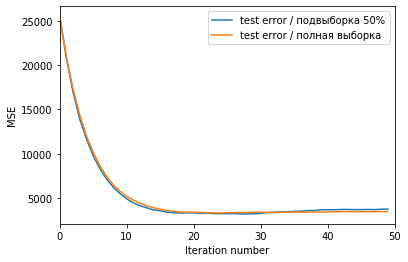

In [29]:
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), test_errors, label='test error / подвыборка 50%')
    plt.plot(list(range(n_trees)), test_errors2, label='test error / полная выборка')
    plt.legend(loc='upper right')
    plt.show()

действительно, обучение на подвыборке 50% практически не влияет на величину ошибки

Попробуем изменять глубину деревьев

In [30]:
eta = 0.1
n_trees=30
max_depth = 5
mse_train=[]
mse_test=[]
for depth in range(1,max_depth+1):
  trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
  mse_train.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
  mse_test.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

mse_train, mse_test

([919.5704161280566,
  937.2415422676974,
  962.6377033625841,
  949.9908409536271,
  905.4436039320835],
 [4020.568076607815,
  3754.7200098727844,
  3753.1291514536533,
  3331.485639487126,
  3546.6951287856045])

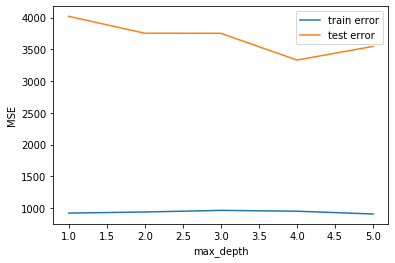

In [32]:
    plt.xlabel('max_depth')
    plt.ylabel('MSE')
    #plt.xlim(0, max_depth)
    plt.plot(list(range(1,max_depth+1)), mse_train, label='train error')
    plt.plot(list(range(1,max_depth+1)), mse_test, label='test error')
    plt.legend(loc='upper right')
    plt.show()

Ошибка на обучающей выборке немного упала, но не так очевидно по сравнению с увеличением числа деревьев, на тестовой ошибка тоже немного упала, потом опять  поднялась, то есть в данном случае можем говорить о появлении переобучения. Параметр нет смысла делать сильно большим. Глубины 2-3, видимо, достаточно